# Assignment 1

Deadline: 19.03.2025, 12:00 CET

Huseyin Albay, 23-744-956, hueseyin.albay@uzh.ch 
Olivier Scokaert, 20-732-095, olivier.scokaert@uzh.ch
Manuel Nützi, 21-701-669, manuelhans.nuetzi@uzh.ch
Bérénice Vielliard, 18-831-966, berenicemariebernadette.vielliard@uzh.ch

In [1]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course/src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [2]:
# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
# mean = <your code here>
mean = np.random.randn(N)
# cov = <your code here>
A = np.random.randn(N, N)
cov = np.dot(A, A.T)

# Generate the Multivariate-Normal random dataset
# data = <your code here>
data = np.random.multivariate_normal(mean, cov, size=T)
print(data.shape)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
# q =  <your code here>
er = ExpectedReturn(method='arithmetic')
q = er.estimate(X=df)
q = er.vector.to_numpy()

# Compute the covariance matrix from df
# P = <your code here>
covar = Covariance()
covar.estimate(X=df)
P = covar.matrix.to_numpy()

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

(1000, 100)
Vector of expected returns (q):
[ 0.27000386 -0.32008616  1.23408046 -0.26948392  1.07366409  1.56880637
  0.75833975  0.21432787  1.16437227  1.26687249  0.37651848  0.3842134
  0.82195795 -0.01319423  1.20743596  0.15885652  1.06799457  0.48612754
  0.06479085 -2.41643418 -0.94174858  0.15748257 -1.67961419 -0.65619389
 -0.0177359  -0.17584692  0.91021803 -2.00328849  1.398694    0.09637194
 -0.62312072  0.89203395 -0.8940928   2.02204139  1.73735096 -1.66267433
 -0.65584545  0.01223552  0.18736008  0.46564759  2.35965638  1.42673689
 -0.76514858 -3.0109512  -2.37292393 -1.99396337 -0.59686525  0.39517975
  0.26397166  0.21326267 -2.77356734  0.32715433 -0.38078297  0.10517016
 -1.5350703   1.66435706  0.68615894 -1.9654195   1.11120875 -1.29190969
 -1.69374323  1.74915575 -0.59450675 -2.40592047  0.50518998  1.2096023
 -2.11275004  0.17180517 -0.11716943  0.55072709 -0.28538739 -1.42620596
  0.0484982  -1.37937225 -0.66468429 -1.44265213  0.2402955  -1.16689337
 -0.24932

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [3]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense="=")

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Add linear constraints
G = pd.DataFrame(0, index=['Group1', 'Group2', 'Group3'], columns=range(1, N+1))
G.loc['Group1', 1:30] = 1
G.loc['Group2', 31:60] = 1
G.loc['Group3', 61:100] = 1 
constraints.add_linear(
    G=G,
    sense=pd.Series(['<=', '<=', '<='], index=G.index),
    rhs=pd.Series([0.3, 0.4, 0.5], index=G.index),
    name="group_constraint_1"
)

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [4]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results
solutions_dct = dict()
for solver in USABLE_SOLVERS:
    qp = QuadraticProgram(P=P, q=q, G=GhAb["G"].astype(np.float64), h=GhAb["h"], A=GhAb["A"], b=GhAb["b"], solver=solver)
    qp.solve()
    solutions_dct[solver] = qp.results["solution"]

Print and visualize the results

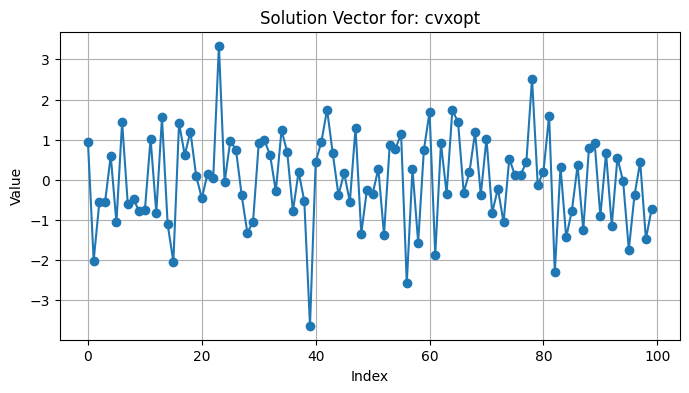

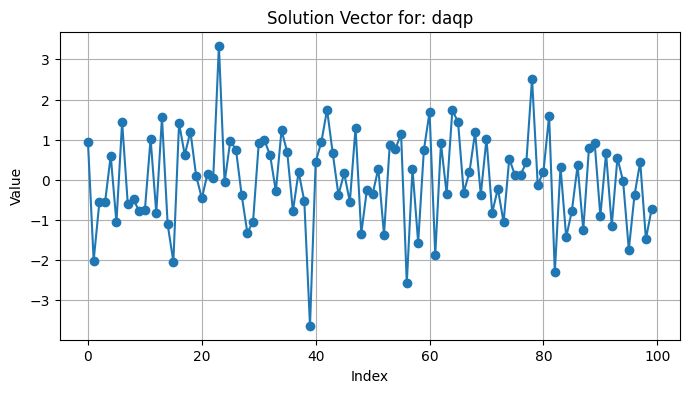

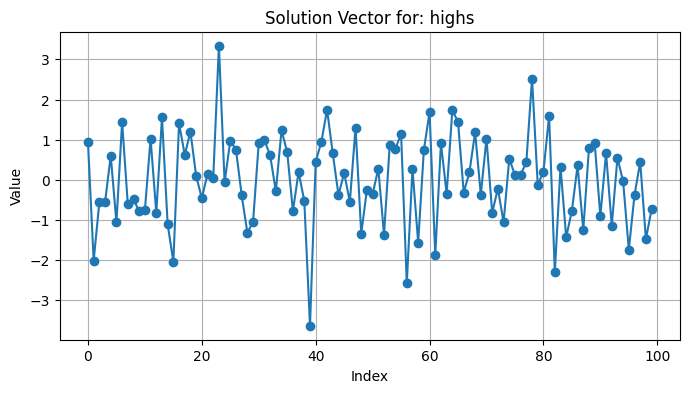

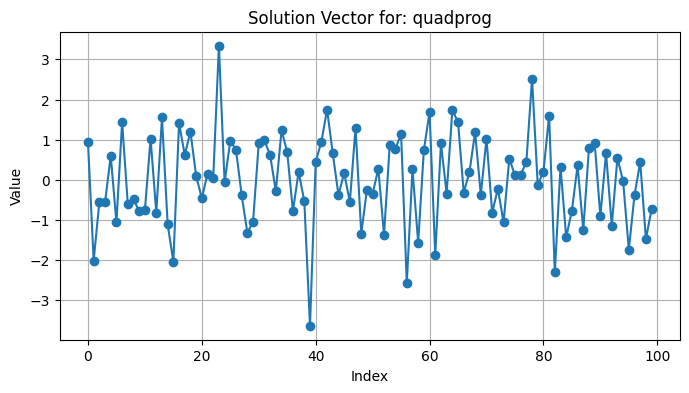

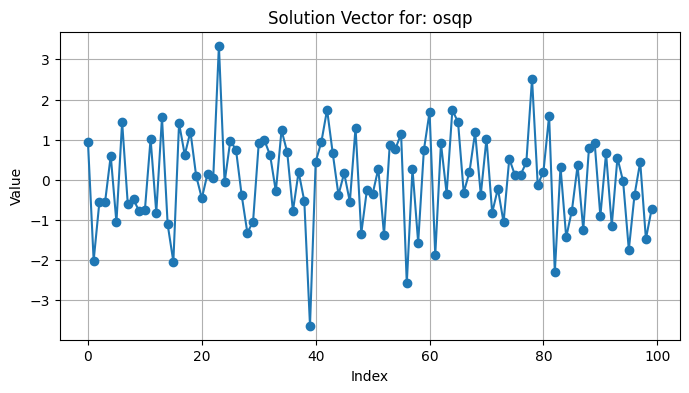

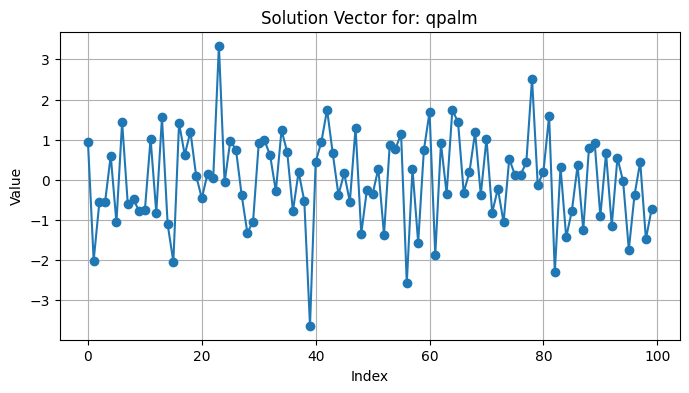

In [5]:
for solver_key, solver_solution in solutions_dct.items():
    #print(solver_solution)
    plt.figure(figsize=(8, 4))
    plt.plot(solver_solution.x, marker='o', linestyle='-')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Solution Vector for: {solver_key}")
    plt.grid()
    plt.show()
    print("\n")

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [6]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        #<your code here>
        # Extract the return series and compute the covariance matrix
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        # Define the objective function for minimum variance
        self.objective = Objective(P = covmat * 2)  # No risk_aversion needed for pure min variance


    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            #<your code here>
            try:
                # Get the covariance matrix
                cov_matrix = self.covariance.estimate(X=opti_data['return_series'], inplace=False)
                # Use pseudoinverse in case the matrix is singular
                inv_cov = np.linalg.pinv(cov_matrix)  

                # Minimum variance portfolio formula: w* = Σ⁻¹1 / (1ᵀ Σ⁻¹ 1)
                ones = np.ones(cov_matrix.shape[0])
                w_optimal = inv_cov @ ones / (ones @ inv_cov @ ones)

                # Store the solution
                self.solution = {"weights": w_optimal}
                return None
            except np.linalg.LinAlgError:
                print("Covariance matrix is singular, falling back to numerical solution.")
                return super().solve()
            #return None
        else:
            return super().solve()



# Create a constraints object with just a budget constraint
constraints_mv = Constraints(ids=df.columns.tolist())
constraints_mv.add_budget(rhs=1, sense="=")

# Instantiate the MinVariance class
covariance_obj = Covariance(matrix=P)
mv = MinVariance(constraints=constraints_mv, covariance=covariance_obj, solver_name="analytical")

# Prepare the optimization data and prepare the optimization problem
opti_data = OptimizationData(return_series=df)

# Solve the optimization problem and print the weights
mv.set_objective(optimization_data=opti_data)
mv.solve()
print(mv.solution["weights"])  

[-4.34479925e-02  1.03388598e-01  2.86788697e-04  2.89211622e-02
 -3.14940936e-03  1.05473800e-01 -8.36810453e-02  5.31182013e-02
  6.73053963e-02  6.43010982e-02  7.67989032e-02 -1.11802444e-02
  7.69958086e-02 -3.86637235e-02  8.75719149e-02  1.07640023e-01
 -1.84952490e-01 -5.26737855e-03 -1.23483439e-01  2.20787695e-02
  9.56662044e-02  5.07879127e-02 -1.47664791e-02 -9.62339447e-02
  3.54501130e-02 -1.12480299e-01 -1.17639699e-02  4.04268732e-02
  1.45052600e-01  1.09727604e-01 -2.77298011e-02 -1.31936824e-02
 -8.70594864e-03  4.58767707e-02 -7.62909707e-02 -6.56457147e-03
  6.46076970e-02  1.42320493e-02  9.87216986e-02  2.81039064e-01
  2.05134269e-02 -4.42603896e-02 -6.98109017e-02  3.55121931e-03
 -3.94776921e-02  4.11298656e-02  5.20287460e-02 -1.34002784e-02
  4.54826324e-02  2.47126579e-02 -1.54524076e-04 -4.66976565e-02
  8.05804519e-02 -2.92313387e-02 -4.78396603e-02 -9.27680217e-02
  2.10083735e-01  4.38331733e-02  1.21016658e-01 -6.96463947e-04
 -1.01302615e-01  1.44151